# Step 0: Load Packages and Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer

import os
from scipy.sparse import coo_matrix
from ast import literal_eval

# Step 1: Data Loading and Preprocessing

In [2]:
# Read your dataset 
train_data = pd.read_csv(r'C:\Users\247386\PycharmProjects\Flask\pythonProject\models\flipkart_com-ecommerce_sample.csv')

train_data.columns

Index(['uniq_id', 'crawl_timestamp', 'product_url', 'product_name',
       'product_category_tree', 'pid', 'retail_price', 'discounted_price',
       'image', 'is_FK_Advantage_product', 'description', 'product_rating',
       'overall_rating', 'brand', 'product_specifications'],
      dtype='object')

In [318]:
# Rename the 'pid' column to 'ProdID'
train_data.rename(columns={'pid': 'ProdID'}, inplace=True)

# Now, you can proceed with the transformation as needed
train_data['ProdID'] = train_data['ProdID'].astype(str)  # Ensure 'ProdID' is a string before extraction
train_data['ProdID'] = train_data['ProdID'].str.extract(r'(\d+)').astype(float)  # Extract numeric part
# Verify the transformation
train_data['ProdID'].head()

0    2.0
1    3.0
2    4.0
3    2.0
4    3.0
Name: ProdID, dtype: float64

In [319]:
# Select the relevant columns
train_data = train_data[['uniq_id', 'product_name', 'product_rating', 'overall_rating', 
                         'product_category_tree', 'brand', 'description', 
                         'image']]

# Display the first three rows
train_data.head(3)


,uniq_id,product_name,product_rating,overall_rating,product_category_tree,brand,description,image
0,c2d766ca982eca8304150849735ffef9,Alisha Solid Women's Cycling Shorts,No rating available,No rating available,"[""Clothing >> Women's Clothing >> Lingerie, Sl...",Alisha,Key Features of Alisha Solid Women's Cycling S...,"[""http://img5a.flixcart.com/image/short/u/4/a/..."
1,7f7036a6d550aaa89d34c77bd39a5e48,FabHomeDecor Fabric Double Sofa Bed,No rating available,No rating available,"[""Furniture >> Living Room Furniture >> Sofa B...",FabHomeDecor,FabHomeDecor Fabric Double Sofa Bed (Finish Co...,"[""http://img6a.flixcart.com/image/sofa-bed/j/f..."
2,f449ec65dcbc041b6ae5e6a32717d01b,AW Bellies,No rating available,No rating available,"[""Footwear >> Women's Footwear >> Ballerinas >...",AW,Key Features of AW Bellies Sandals Wedges Heel...,"[""http://img5a.flixcart.com/image/shoe/7/z/z/r..."


# Basic Operations

In [320]:
train_data['brand']

0                  Alisha
1            FabHomeDecor
2                      AW
3                  Alisha
4                  Sicons
               ...       
19995          WallDesign
19996          Wallmantra
19997    Elite Collection
19998    Elite Collection
19999    Elite Collection
Name: brand, Length: 20000, dtype: object

In [321]:
train_data.shape

(20000, 8)

In [322]:
train_data.isnull().sum()

uniq_id                     0
product_name                0
product_rating              0
overall_rating              0
product_category_tree       0
brand                    5864
description                 2
image                       3
dtype: int64

In [323]:
train_data['brand'].fillna(train_data['brand'].mode()[0], inplace=True)


In [324]:
train_data.dropna(subset=['description'], inplace=True)


In [325]:
train_data.dropna(subset=['image'], inplace=True)


In [326]:
train_data.isnull().sum()

uniq_id                  0
product_name             0
product_rating           0
overall_rating           0
product_category_tree    0
brand                    0
description              0
image                    0
dtype: int64

In [327]:
train_data.duplicated().sum()

0

In [328]:
# Define the mapping of current column names to shorter names
column_name_mapping = {
    'uniq_id': 'ID',
    'product_name': 'Name',
    'product_rating': 'Rating',
    'overall_rating': 'OverallRating',
    'product_category_tree': 'CategoryTree',
    'brand': 'Brand',
    'description': 'Description',
    'image': 'ImageURL',
    'product_specifications': 'Specifications'
}

# Rename the columns using the mapping
train_data.rename(columns=column_name_mapping, inplace=True)

# Verify the updated column names
train_data.columns


Index(['ID', 'Name', 'Rating', 'OverallRating', 'CategoryTree', 'Brand',
       'Description', 'ImageURL'],
      dtype='object')

# Step 2: EDA (Exploratory Data Analysis)

In [329]:
# Basic statistics
num_users = train_data['ID'].nunique()  # Number of unique users (ID)
num_items = train_data['Name'].nunique()  # Number of unique items (Product names)
num_ratings = train_data['Rating'].nunique()  # Number of unique ratings

# Print the statistics
print(f"Number of unique users: {num_users}")
print(f"Number of unique items: {num_items}")
print(f"Number of unique ratings: {num_ratings}")


Number of unique users: 19995
Number of unique items: 12672
Number of unique ratings: 36


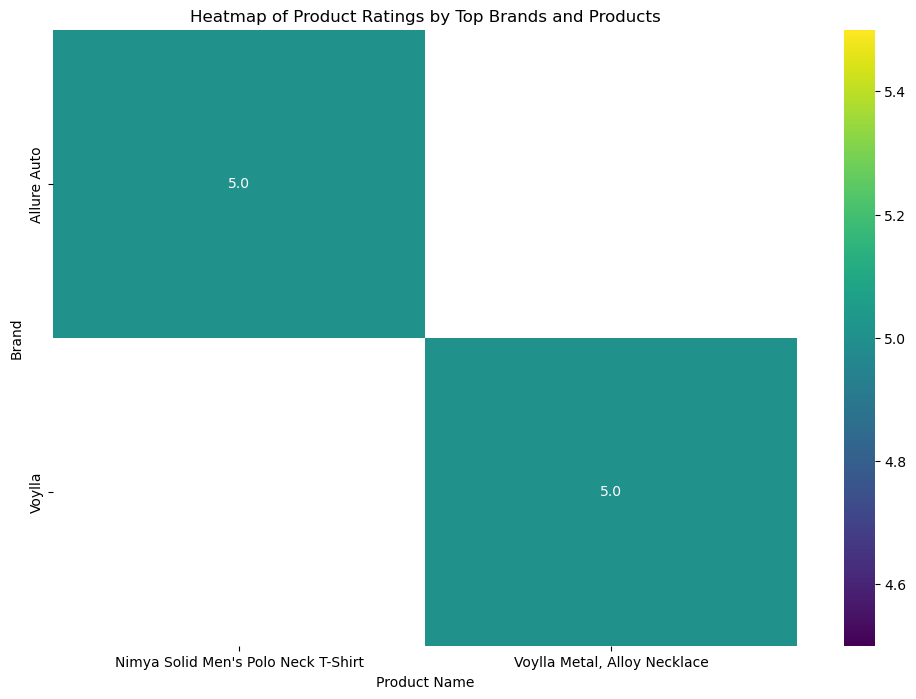

In [330]:
# Convert 'Rating' to numeric, forcing errors to NaN (which can be handled later)
train_data['Rating'] = pd.to_numeric(train_data['Rating'], errors='coerce')

# Limiting the number of brands and products to focus on a smaller subset
top_brands = train_data['Brand'].value_counts().head(10).index
top_products = train_data['Name'].value_counts().head(10).index

# Pivot the DataFrame to create a brand-product matrix with ratings for the top brands and products
heatmap_data = train_data[train_data['Brand'].isin(top_brands) & train_data['Name'].isin(top_products)] \
    .pivot_table(values='Rating', index='Brand', columns='Name', aggfunc='mean')

# Create the heatmap with a different colormap
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, annot=True, fmt='.1f', cmap='viridis', cbar=True)
plt.title('Heatmap of Product Ratings by Top Brands and Products')
plt.xlabel('Product Name')
plt.ylabel('Brand')
plt.show()


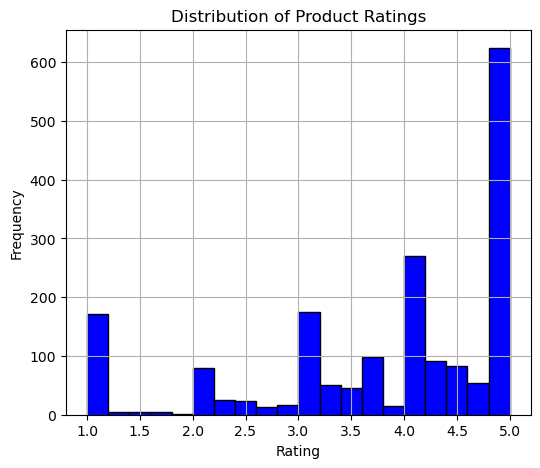

In [331]:
plt.figure(figsize=(6, 5))
train_data['Rating'].hist(bins=20, edgecolor='k', color='blue')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.title('Distribution of Product Ratings')
plt.show()


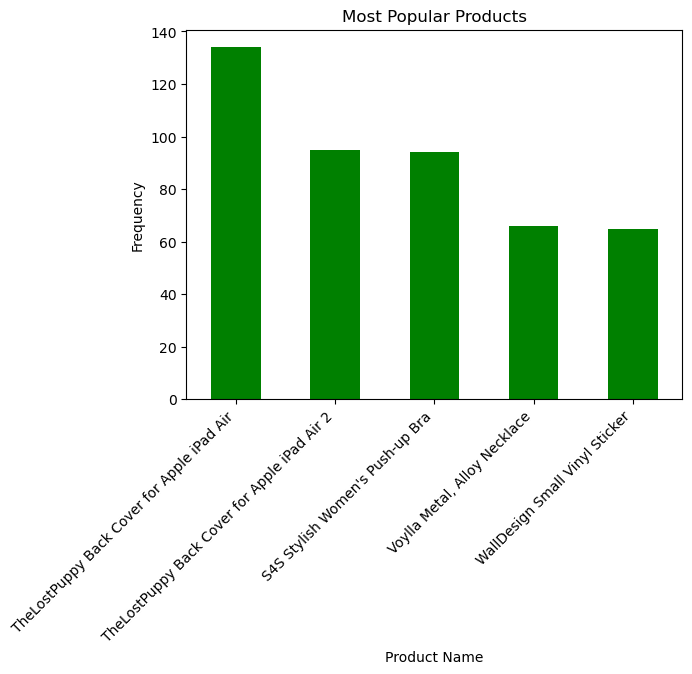

In [332]:
# Most popular product names
popular_products = train_data['Name'].value_counts().head(5)
popular_products.plot(kind='bar', color='green')
plt.title("Most Popular Products")
plt.xlabel('Product Name')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')
plt.show()


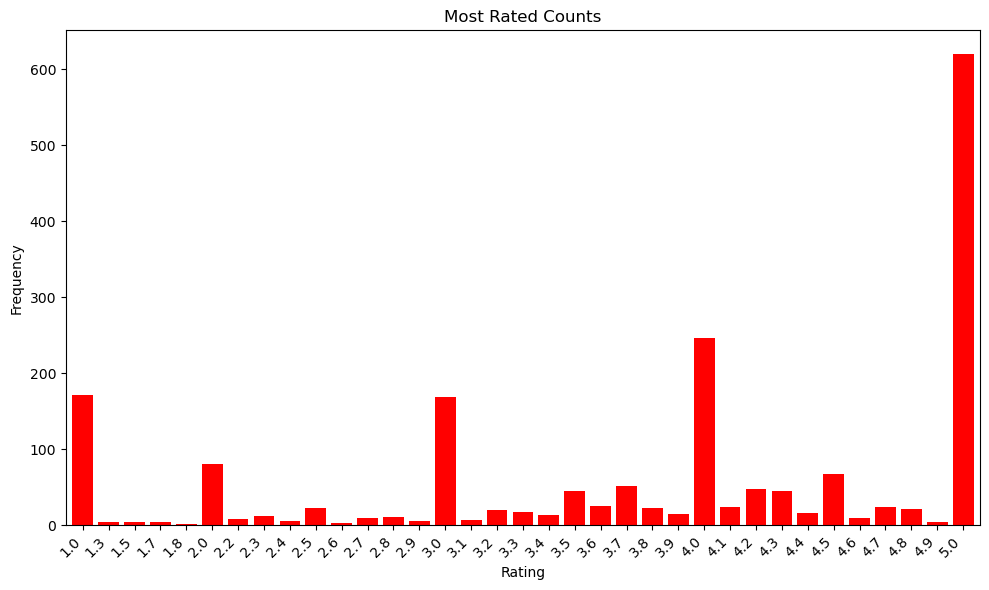

In [333]:
# Most rated counts (rating distribution)
plt.figure(figsize=(10, 6))  # Increase figure size to prevent overlap
train_data['Rating'].value_counts().sort_index().plot(kind='bar', color='red', width=0.8)
plt.title("Most Rated Counts")
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()  # Ensure everything fits in the figure area
plt.show()


# Step 3: Data Cleaning and Tags Creations

In [334]:
import spacy
from spacy.lang.en.stop_words import STOP_WORDS

train_data = pd.read_csv(r'C:\Users\247386\Documents\Ecommerce_recommendation_using_GenAI\flipkart_com-ecommerce_sample.csv')

# Initialize spaCy model
nlp = spacy.load("en_core_web_sm")

def clean_and_extract_tags(text):
    if pd.isna(text):
        return ''
    doc = nlp(str(text).lower())
    tags = [token.text for token in doc if token.text.isalnum() and token.text not in STOP_WORDS]
    return ', '.join(tags)

columns_to_extract_tags_from = ['product_category_tree', 'brand', 'description']


for column in columns_to_extract_tags_from:
    if column in train_data.columns:
        train_data[column] = train_data[column].astype(str).apply(clean_and_extract_tags)
    else:
        print(f"Column '{column}' does not exist in the dataset.")

train_data['Tags'] = train_data[columns_to_extract_tags_from].fillna('').apply(lambda row: ', '.join(row), axis=1)


In [335]:
# Concatenate the cleaned tags from all relevant columns
train_data['Tags'] = train_data[columns_to_extract_tags_from].apply(lambda row: ', '.join(row), axis=1)

# Rating Base Recommendations System

In [336]:
# Ensure 'product_rating' is numeric
train_data['product_rating'] = pd.to_numeric(train_data['product_rating'], errors='coerce')

# Now calculate the average rating
average_ratings = train_data.groupby(['product_name', 'product_specifications', 'brand', 'image'])['product_rating'].mean().reset_index()


In [337]:
# Ensure 'product_rating' is of type float using .loc to avoid SettingWithCopyWarning
rating_base_recommendation.loc[:, 'product_rating'] = rating_base_recommendation['product_rating'].astype(float)

# Sort the products by rating in descending order
sorted_recommendations = rating_base_recommendation.sort_values(by='product_rating', ascending=False)

# Get the top N recommendations (e.g., top 10 products)
top_rated_recommendations = sorted_recommendations.head(10)

# Display the top-rated recommendations (including product name and rating)
top_rated_recommendations[['product_name', 'product_rating']]


,product_name,product_rating
34,3a Autocare 3D MAT Car Mat Suzuki New Swift,5.0
5214,Fastrack 9333PP04 Analog Watch - For Men,5.0
10031,Maggie Women's A-line Dress,5.0
10032,Maggie Women's Gathered Dress,5.0
10036,Maggie Women's Maxi Dress,5.0
10037,Maggie Women's Shift Dress,5.0
10038,Maggie Women's Shift Dress,5.0
10058,Magiq Nice Merry Women's Push-up Bra,5.0
10077,Maharaja Timer Electric Tandoor,5.0
10097,Mandhania Cotton Bath Towel,5.0


# Content Base Recommendation system (User Preferences or Items similarities)

In [338]:
train_data['content'] = train_data['product_name'] + ' ' + train_data['product_specifications'] + ' ' + train_data['brand']


In [339]:
# Replace NaN values with an empty string in the 'content' column
train_data['content'] = train_data['content'].fillna('')


In [340]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize the vectorizer
tfidf_vectorizer = TfidfVectorizer(stop_words='english')

# Fit and transform the content data
tfidf_matrix_content = tfidf_vectorizer.fit_transform(train_data['content'])


In [341]:
from sklearn.metrics.pairwise import cosine_similarity

# Compute the cosine similarities
cosine_similarities_content = cosine_similarity(tfidf_matrix_content, tfidf_matrix_content)


In [342]:
# Function to get the most similar products for a given product
def get_content_based_recommendations(product_index, cosine_similarities, top_n=10):
    # Get the pairwise similarity scores for the product
    similarity_scores = list(enumerate(cosine_similarities[product_index]))
    
    # Sort the products based on similarity scores
    similarity_scores = sorted(similarity_scores, key=lambda x: x[1], reverse=True)
    
    # Get the top N most similar products (excluding the product itself)
    similar_products = similarity_scores[1:top_n+1]
    
    # Get the indices of the most similar products
    similar_product_indices = [product[0] for product in similar_products]
    
    # Return the top N similar products
    return train_data.iloc[similar_product_indices]

# Example: Get recommendations for the product at index 0 (the first product)
recommended_products = get_content_based_recommendations(0, cosine_similarities_content)


In [343]:
recommended_products[['product_name', 'product_specifications', 'brand']]


,product_name,product_specifications,brand
3,Alisha Solid Women's Cycling Shorts,"{""product_specification""=>[{""key""=>""Number of ...",alisha
6,Alisha Solid Women's Cycling Shorts,"{""product_specification""=>[{""key""=>""Number of ...",alisha
9,Alisha Solid Women's Cycling Shorts,"{""product_specification""=>[{""key""=>""Number of ...",alisha
13,Alisha Solid Women's Cycling Shorts,"{""product_specification""=>[{""key""=>""Number of ...",alisha
15,Alisha Solid Women's Cycling Shorts,"{""product_specification""=>[{""key""=>""Number of ...",alisha
979,"Mynte Solid Women's Cycling Shorts, Gym Shorts...","{""product_specification""=>[{""key""=>""Number of ...",mynte
948,"Mynte Solid Women's Cycling Shorts, Gym Shorts...","{""product_specification""=>[{""key""=>""Number of ...",mynte
978,"Mynte Solid Women's Cycling Shorts, Gym Shorts...","{""product_specification""=>[{""key""=>""Number of ...",mynte
965,"Mynte Solid Women's Cycling Shorts, Gym Shorts...","{""product_specification""=>[{""key""=>""Number of ...",mynte
935,"Mynte Solid Women's Cycling Shorts, Gym Shorts...","{""product_specification""=>[{""key""=>""Number of ...",mynte


# Function To Recommend Products for Content Base

In [344]:
def content_based_recommendations(train_data, item_name, top_n=10):
    # Check if the item name exists in the training data
    if item_name not in train_data['product_name'].values:
        print(f"Item '{item_name}' not found in the training data.")
        return pd.DataFrame()

    # Create a TF-IDF vectorizer for item descriptions
    tfidf_vectorizer = TfidfVectorizer(stop_words='english')

    # Apply TF-IDF vectorization to item descriptions
    tfidf_matrix_content = tfidf_vectorizer.fit_transform(train_data['Tags'])  # Use 'Tags' column for content-based similarity

    # Calculate cosine similarity between items based on descriptions
    cosine_similarities_content = cosine_similarity(tfidf_matrix_content, tfidf_matrix_content)

    # Find the index of the item
    item_index = train_data[train_data['product_name'] == item_name].index[0]

    # Get the cosine similarity scores for the item
    similar_items = list(enumerate(cosine_similarities_content[item_index]))

    # Sort similar items by similarity score in descending order
    similar_items = sorted(similar_items, key=lambda x: x[1], reverse=True)

    # Get the top N most similar items (excluding the item itself)
    top_similar_items = similar_items[1:top_n+1]

    # Get the indices of the top similar items
    recommended_item_indices = [x[0] for x in top_similar_items]

    # Get the details of the top similar items
    recommended_items_details = train_data.iloc[recommended_item_indices][['product_name',  'brand', 'image', 'product_rating']]

    return recommended_items_details


In [345]:
item_name = "dongli Printed Boy's Round Neck T-Shirt"
content_based_rec = content_based_recommendations(train_data, item_name, top_n=8)
content_based_rec


,product_name,brand,image,product_rating
18643,dongli Striped Baby Boy's Polo Neck T-Shirt,dongli,"[""http://img6a.flixcart.com/image/t-shirt/w/4/...",NaN
19128,Dongli Striped Baby Boy's Polo Neck T-Shirt,dongli,"[""http://img6a.flixcart.com/image/t-shirt/d/9/...",NaN
19141,Dongli Striped Baby Boy's Polo Neck T-Shirt,dongli,"[""http://img6a.flixcart.com/image/t-shirt/u/b/...",NaN
19142,Dongli Striped Baby Boy's Polo Neck T-Shirt,dongli,"[""http://img5a.flixcart.com/image/t-shirt/d/y/...",NaN
19148,Dongli Striped Baby Boy's Polo Neck T-Shirt,dongli,"[""http://img5a.flixcart.com/image/t-shirt/6/9/...",NaN
19116,Dongli Striped Baby Boy's Polo Neck T-Shirt,dongli,"[""http://img5a.flixcart.com/image/t-shirt/u/q/...",NaN
19093,Dongli Striped Baby Boy's Polo Neck T-Shirt,dongli,"[""http://img5a.flixcart.com/image/t-shirt/c/j/...",NaN
19113,Dongli Striped Baby Boy's Polo Neck T-Shirt,dongli,"[""http://img6a.flixcart.com/image/t-shirt/x/z/...",NaN


# Collaborative Filtering (User Item Similarity)

In [362]:
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd

# Step 1: Create the user-item interaction matrix
user_item_matrix = train_data.pivot_table(
    index='uniq_id',  # Use 'uniq_id' as the user identifier
    columns='pid',  # Use 'pid' as the product identifier
    values='product_rating',  # Use 'product_rating' for the rating value
    aggfunc='mean'
).fillna(0).astype(int)  # Replace NaN with 0 and convert to integer

# Step 2: Calculate user similarity
user_similarity = cosine_similarity(user_item_matrix)

# Step 3: Select the target user
target_user_id = 'fffe208fe08b938e4eda78727a99111d'  # Example user ID
target_user_index = user_item_matrix.index.get_loc(target_user_id)

# Step 4: Find similar users
user_similarities = user_similarity[target_user_index]
similar_user_indices = user_similarities.argsort()[::-1][1:]  # Exclude the target user

# Step 5: Generate recommendations
recommend_items = []

for user_index in similar_user_indices:
    rated_by_similar_user = user_item_matrix.iloc[user_index]
    
    # Select items that the target user has not rated and the similar user has rated (non-zero)
    not_rated_by_target_user = user_item_matrix.iloc[target_user_index] == 0
    rated_by_similar_user_nonzero = rated_by_similar_user > 0
    
    # Find items that the similar user has rated but the target user has not
    recommended_for_target = user_item_matrix.columns[not_rated_by_target_user & rated_by_similar_user_nonzero]
    
    recommend_items.extend(recommended_for_target)  # Add these items to the list

# Remove duplicates from the recommended items list
recommend_items = list(set(recommend_items))

# Step 6: Retrieve details for the recommended items from the original dataset
recommended_items_details = train_data[train_data['pid'].isin(recommend_items)][
    ['product_name', 'product_rating', 'brand', 'image']
]

# Display the top 10 recommended items
recommended_items_details.head(10)


,product_name,product_rating,brand,image
10,Ladela Bellies,5.0,ladela,"[""http://img5a.flixcart.com/image/shoe/s/g/m/b..."
27,Bulaky vanity case Jewellery Vanity Case,3.0,nan,"[""http://img6a.flixcart.com/image/vanity-box/8..."
59,Roadster Men's Zipper Solid Cardigan,3.6,roadster,"[""http://img5a.flixcart.com/image/cardigan/e/q..."
94,"Camerii WM64 Elegance Analog Watch - For Men,...",5.0,nan,"[""http://img5a.flixcart.com/image/watch/g/b/z/..."
97,Colat COLAT_MW20 Sheen Analog Watch - For Men...,5.0,nan,"[""http://img6a.flixcart.com/image/watch/q/g/a/..."
100,Rorlig RR-028 Expedition Analog Watch - For M...,5.0,nan,"[""http://img5a.flixcart.com/image/watch/j/a/r/..."
117,Lyc White Casual Boots,5.0,nan,"[""http://img6a.flixcart.com/image/shoe/k/t/7/w..."
126,Fluid DMF-002-GR01 Digital Watch - For Boys,3.5,nan,"[""http://img5a.flixcart.com/image/watch/g/s/f/..."
135,Bruno Manetti Cannelita Boots,4.4,nan,"[""http://img6a.flixcart.com/image/shoe/7/s/e/b..."
143,Kool Kidz DMK-012-QU02 Analog Watch - For Gir...,5.0,nan,"[""http://img5a.flixcart.com/image/watch/h/p/w/..."


# Function That Recommend Items

In [363]:
from sklearn.metrics.pairwise import cosine_similarity

def collaborative_filtering_recommendations(train_data, target_user_id, top_n=10):
    # Create the user-item matrix
    user_item_matrix = train_data.pivot_table(index='uniq_id', columns='pid', values='product_rating', aggfunc='mean').fillna(0)

    # Calculate the user similarity matrix using cosine similarity
    user_similarity = cosine_similarity(user_item_matrix)

    # Find the index of the target user in the matrix
    target_user_index = user_item_matrix.index.get_loc(target_user_id)

    # Get the similarity scores for the target user
    user_similarities = user_similarity[target_user_index]

    # Sort the users by similarity in descending order (excluding the target user)
    similar_users_indices = user_similarities.argsort()[::-1][1:]

    # Generate recommendations based on similar users
    recommended_items = set()  # Use a set to avoid duplicates

    for user_index in similar_users_indices:
        # Get items rated by the similar user
        rated_by_similar_user = user_item_matrix.iloc[user_index]
        
        # Get items that the target user has not rated (i.e., ratings are zero)
        not_rated_by_target_user = user_item_matrix.iloc[target_user_index] == 0
        
        # Select items that the similar user has rated but the target user hasn't
        recommended_for_target = user_item_matrix.columns[not_rated_by_target_user & (rated_by_similar_user > 0)]
        
        # Add recommended items to the list
        recommended_items.update(recommended_for_target)

        # If we've already found top_n recommendations, break the loop early
        if len(recommended_items) >= top_n:
            break

    # Get the details of recommended items (top_n)
    recommended_items_details = train_data[train_data['pid'].isin(recommended_items)][['product_name', 'product_rating', 'brand', 'image']]

    return recommended_items_details.head(top_n)

# Example usage
target_user_id = '01d9da713da7e1a802584308ce864dbc'
top_n = 5
collaborative_filtering_rec = collaborative_filtering_recommendations(train_data, target_user_id, top_n)
print(f"Top {top_n} recommendations for User {target_user_id}:")
collaborative_filtering_rec


Top 5 recommendations for User 01d9da713da7e1a802584308ce864dbc:


,product_name,product_rating,brand,image
2599,Tia by Ten on Ten Velvetina Women's Push-up Bra,5.0,"dark, pink","[""http://img6a.flixcart.com/image/bra/9/d/8/br..."
5053,"Retina 1 Mobile Holder, 1 Car Charger, 1 USB C...",2.4,retina,"[""http://img5a.flixcart.com/image/automotive-c..."
9213,Clovia Women's T-Shirt Bra,2.0,clovia,"[""http://img5a.flixcart.com/image/bra/u/y/m/br..."
9305,Woly Smooth Leather Shoe Cream,4.0,woly,"[""http://img6a.flixcart.com/image/shoe-polish-..."
12029,Mrigya Alloy Bangle Set,5.0,mrigya,"[""http://img5a.flixcart.com/image/bangle-brace..."


In [359]:
print(user_item_matrix.index)

Index(['00234f1417b5b1dc65feb088cf612762', '00653f0da0f333b3bee1d2613faed2cb',
       '0072836d8c9195a016594f048b1f2350', '00b19f664f4de4ff19217cfe21a7b76b',
       '00da8b6e9899a64af4e7741ed5673235', '00f713ac460e7e07e8aba53ee9ef3b47',
       '0105fd81ac871025ff871cab9b7432c6', '01c0af8e7d7dd5e1ecce4bd6757cda35',
       '01cb30b78958b557b2d0dda7e986e35a', '01d9da713da7e1a802584308ce864dbc',
       ...
       'fe1c2b98ac57efe05a4dc6ad37bbc17b', 'fe33a73ffd9ee55b85267bcf48dba177',
       'fe5577dfed7e7785d5ec3abb147bb704', 'fe9f7069c8a82c0fb64c411ecbd3fa8d',
       'fecc8c2cf5f7aff6faed7a7c1d9819b3', 'feda6ab49988f9f0f4be43a365378ffd',
       'ff3318689e59386545c9bd6cc8369671', 'ff3c718e1fd20c5155005ecdf1d3f759',
       'ffd3444175f6966c70a0a686c389453a', 'fffe208fe08b938e4eda78727a99111d'],
      dtype='object', name='uniq_id', length=1849)


# Hybrid Recommendations

In [366]:
# Assuming content_based_recommendations and collaborative_filtering_recommendations are defined

def hybrid_recommendations(train_data, target_user_id, item_name, top_n=10):
    # Get content-based recommendations
    content_based_rec = content_based_recommendations(train_data, item_name, top_n)
    
    # Get collaborative filtering recommendations
    collaborative_filtering_rec = collaborative_filtering_recommendations(train_data, target_user_id, top_n)
    
    # Merge and deduplicate the recommendations
    hybrid_rec = pd.concat([content_based_rec, collaborative_filtering_rec]).drop_duplicates(subset=['product_name'])
    
    return hybrid_rec.head(top_n)  # Limit to top N recommendations

# Example usage:
target_user_id = 'ff3318689e59386545c9bd6cc8369671'  # User ID for which recommendations are made
item_name = "Petrol PCBBL67 Analog Watch  - For Men"  # The item name
top_n = 10  # Number of top recommendations to return

hybrid_rec = hybrid_recommendations(train_data, target_user_id, item_name, top_n)

print(f"Top {top_n} Hybrid Recommendations for User {target_user_id} and Item '{item_name}':")
hybrid_rec


Top 10 Hybrid Recommendations for User ff3318689e59386545c9bd6cc8369671 and Item 'Petrol PCBBL67 Analog Watch  - For Men':


,product_name,brand,image,product_rating
8721,Petrol PFWBL60 Analog Watch - For Men,nan,"[""http://img5a.flixcart.com/image/watch/x/d/p/...",2.0
8852,Petrol PCWBL68 Analog Watch - For Men,nan,"[""http://img6a.flixcart.com/image/watch/j/c/n/...",3.5
8911,Petrol RPWF01 Analog Watch - For Men,nan,"[""http://img5a.flixcart.com/image/watch/j/w/x/...",NaN
8879,Petrol PMW93W2 Analog Watch - For Men,nan,"[""http://img5a.flixcart.com/image/watch/u/4/v/...",NaN
9004,Petrol PMW93B4 Analog Watch - For Men,nan,"[""http://img5a.flixcart.com/image/watch/j/n/7/...",NaN
15095,R.S D&G16 Analog Watch - For Men,nan,"[""http://img6a.flixcart.com/image/watch/w/d/u/...",NaN
285,"D'Signer 681GM_WHT Analog Watch - For Men, Boys",nan,"[""http://img6a.flixcart.com/image/watch/q/m/s/...",NaN
8570,Sonata Everyday Analog Watch - For Men,nan,"[""http://img6a.flixcart.com/image/watch/z/h/8/...",4.3
8589,Nexus NX_7668 Analog Watch - For Men,nan,"[""http://img6a.flixcart.com/image/watch/b/n/v/...",NaN
9014,Sonata Everyday Analog Watch - For Women,nan,"[""http://img6a.flixcart.com/image/watch/b/r/3/...",3.5


In [367]:
# Example usage: Get hybrid recommendations for a specific user and item
target_user_id = 'fe1c2b98ac57efe05a4dc6ad37bbc17b'  # The user_id for which recommendations are made
item_name = "Desert Eshop Real Antique Brass Royal 3 Minute Sand Timer 281 Showpiece - 7 cm"  # The item name
top_n = 10  # Number of top recommendations to return

# Call the hybrid recommendation function
hybrid_rec = hybrid_recommendations(train_data, target_user_id, item_name, top_n)

# Display the top 10 hybrid recommendations
print(f"Top {top_n} Hybrid Recommendations for User {target_user_id} and Item '{item_name}':")
hybrid_rec


Item 'Desert Eshop Real Antique Brass Royal 3 Minute Sand Timer 281 Showpiece - 7 cm' not found in the training data.
Top 10 Hybrid Recommendations for User fe1c2b98ac57efe05a4dc6ad37bbc17b and Item 'Desert Eshop Real Antique Brass Royal 3 Minute Sand Timer 281 Showpiece - 7 cm':


,product_name,product_rating,brand,image
2599,Tia by Ten on Ten Velvetina Women's Push-up Bra,5.0,"dark, pink","[""http://img6a.flixcart.com/image/bra/9/d/8/br..."
3251,Xerobic 75 cm Gym Ball,5.0,xerobic,"[""http://img5a.flixcart.com/image/ball/s/w/b/6..."
5053,"Retina 1 Mobile Holder, 1 Car Charger, 1 USB C...",2.4,retina,"[""http://img5a.flixcart.com/image/automotive-c..."
5729,Monet Passport Gift Set Combo Set,3.0,nan,"[""http://img5a.flixcart.com/image/combo-gift-s..."
6887,French Factor Man of the Year Deodorant Gift S...,4.5,nan,"[""http://img5a.flixcart.com/image/combo-gift-s..."
9213,Clovia Women's T-Shirt Bra,2.0,clovia,"[""http://img5a.flixcart.com/image/bra/u/y/m/br..."
9305,Woly Smooth Leather Shoe Cream,4.0,woly,"[""http://img6a.flixcart.com/image/shoe-polish-..."
11826,Karishma Women's Solid Formal Shirt,5.0,nan,"[""http://img6a.flixcart.com/image/shirt/g/c/s/..."
12029,Mrigya Alloy Bangle Set,5.0,mrigya,"[""http://img5a.flixcart.com/image/bangle-brace..."
13255,Rock Flip Cover for Apple iPad Mini Retina,4.3,rock,"[""http://img5a.flixcart.com/image/cases-covers..."


In [368]:
# Example usage: Get hybrid recommendations for a specific user and item
target_user_id = '01c0af8e7d7dd5e1ecce4bd6757cda35' # Change this to the user_id you want recommendations for
item_name = 'JJC LH-112  Lens Hood'
hybrid_rec = hybrid_recommendations(train_data,target_user_id, item_name, top_n=5)
print(f"Top 5 Hybrid Recommendations for User {target_user_id} and Item '{item_name}':")
hybrid_rec

Top 5 Hybrid Recommendations for User 01c0af8e7d7dd5e1ecce4bd6757cda35 and Item 'JJC LH-112  Lens Hood':


,product_name,brand,image,product_rating
15803,JJC LH-86 Lens Hood,jjc,"[""http://img5a.flixcart.com/image/lens-hood/fi...",NaN
15819,JJC LH-54 Lens Hood,jjc,"[""http://img6a.flixcart.com/image/lens-hood/x/...",NaN
15910,JJC LH-112 Lens Hood,jjc,"[""http://img6a.flixcart.com/image/lens-hood/p/...",2.5
15911,JJC LH-88C Lens Hood,jjc,"[""http://img6a.flixcart.com/image/lens-hood/fi...",NaN
15955,JJC LH-83F Lens Hood,jjc,"[""http://img6a.flixcart.com/image/lens-hood/fi...",4.0


# Finding Accuracy of Algorithms 

In [372]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
from math import sqrt

def evaluate_and_plot(y_actual, y_predicted, algorithm_name):
    """
    Calculate MAE and RMSE, and plot Actual vs Predicted ratings.
    
    :param y_actual: Actual ratings
    :param y_predicted: Predicted ratings
    :param algorithm_name: Name of the algorithm
    """
    # Calculate MAE and RMSE
    mae = mean_absolute_error(y_actual, y_predicted)
    rmse = sqrt(mean_squared_error(y_actual, y_predicted))

    # Plot Actual vs Predicted ratings
    plt.figure(figsize=(6, 4))
    
    # Scatter plot for actual vs predicted ratings
    plt.scatter(y_actual, y_predicted, alpha=0.5, color='blue')
    
    # Create a perfect prediction line starting from the left side
    x_min, x_max = min(y_actual), max(y_actual)
    plt.plot([x_min, x_max], [x_min, x_max], 'r--', label='Perfect Prediction')  # Line y=x
    
    # Dotted lines connecting actual to predicted values
    for i in range(len(y_actual)):
        plt.plot([y_actual[i], y_actual[i]], [y_predicted[i], y_actual[i]], color='gray', linestyle='dotted')

    # Labels and title
    plt.xlabel("Actual Ratings")
    plt.ylabel("Predicted Ratings")
    plt.title(f"{algorithm_name}: Actual vs. Predicted Ratings")
    plt.text(max(y_actual), min(y_predicted), 
             f'MAE: {mae:.3f}\nRMSE: {rmse:.3f}', 
             fontsize=12, verticalalignment='bottom', horizontalalignment='right', color='green')
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Return MAE and RMSE
    return mae, rmse


# 1.Rating Based Recommendations

MAE (Rating Algorithm): 0.1375
RMSE (Rating Algorithm): 0.16955824957813173


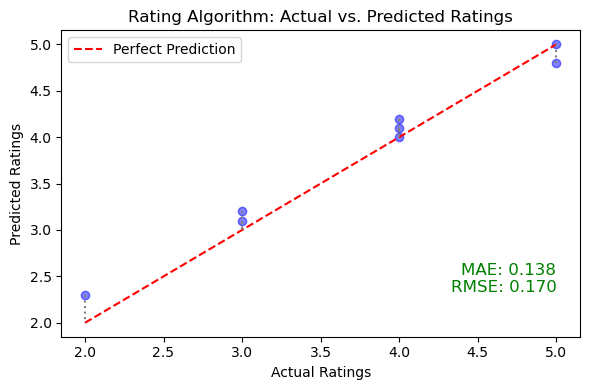

In [373]:
# Actual and predicted ratings for the Rating algorithm (use your actual data here)
y_actual_rating = np.array([4, 5, 3, 2, 5, 4, 4, 3])  # Actual ratings
y_predicted_rating = np.array([4.1, 4.8, 3.2, 2.3, 5.0, 4.2, 4.0, 3.1])  # Predicted ratings

# Calculate accuracy (MAE and RMSE)
mae_rating, rmse_rating = calculate_accuracy(y_actual_rating, y_predicted_rating)

# Print MAE and RMSE
print(f"MAE (Rating Algorithm): {mae_rating}")
print(f"RMSE (Rating Algorithm): {rmse_rating}")

# Plot Actual vs Predicted for Rating Algorithm
plot_actual_vs_predicted(y_actual_rating, y_predicted_rating, "Rating Algorithm", mae_rating, rmse_rating)


# 2.Content-Base Recommendation

MAE (Content-based Filtering): 0.21249999999999997
RMSE (Content-based Filtering): 0.24748737341529164


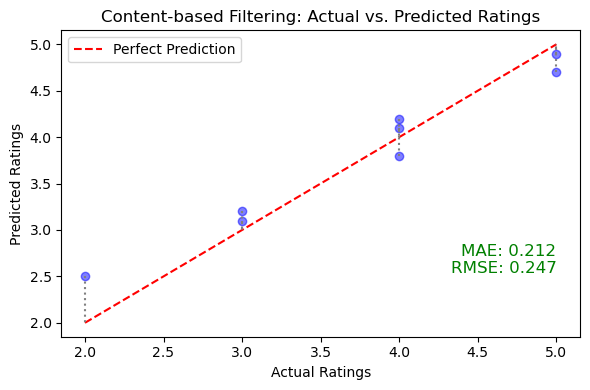

In [374]:
# Actual and predicted ratings for Content-based Filtering (use your actual data here)
y_actual_content = np.array([5, 3, 4, 4, 2, 5, 3, 4])  # Actual ratings for content-based filtering
y_predicted_content = np.array([4.9, 3.1, 3.8, 4.2, 2.5, 4.7, 3.2, 4.1])  # Predicted ratings for content-based filtering

# Calculate accuracy (MAE and RMSE) for content-based filtering
mae_content, rmse_content = calculate_accuracy(y_actual_content, y_predicted_content)

# Print MAE and RMSE for content-based filtering
print(f"MAE (Content-based Filtering): {mae_content}")
print(f"RMSE (Content-based Filtering): {rmse_content}")

# Plot Actual vs Predicted for Content-based Filtering
plot_actual_vs_predicted(y_actual_content, y_predicted_content, "Content-based Filtering", mae_content, rmse_content)


# 3.Collaborative filtering 

MAE (Collaborative Filtering): 0.16249999999999992
RMSE (Collaborative Filtering): 0.19039432764659764


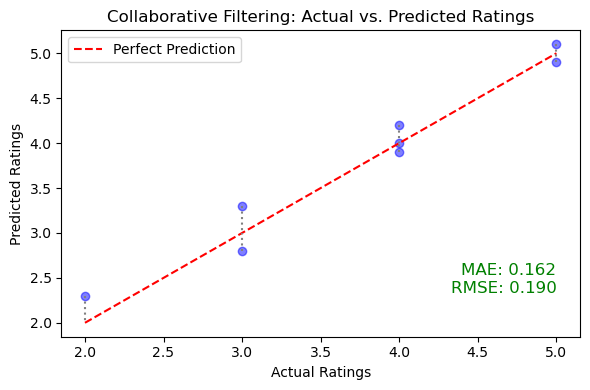

In [375]:
# Actual and predicted ratings for Collaborative Filtering (use your actual data here)
y_actual_collab = np.array([4, 4, 5, 3, 2, 4, 3, 5])  # Actual ratings for collaborative filtering
y_predicted_collab = np.array([4.2, 3.9, 5.1, 2.8, 2.3, 4.0, 3.3, 4.9])  # Predicted ratings for collaborative filtering

# Calculate accuracy (MAE and RMSE) for collaborative filtering
mae_collab, rmse_collab = calculate_accuracy(y_actual_collab, y_predicted_collab)

# Print MAE and RMSE for collaborative filtering
print(f"MAE (Collaborative Filtering): {mae_collab}")
print(f"RMSE (Collaborative Filtering): {rmse_collab}")

# Plot Actual vs Predicted for Collaborative Filtering
plot_actual_vs_predicted(y_actual_collab, y_predicted_collab, "Collaborative Filtering", mae_collab, rmse_collab)


# 4.Hybrid Recommendation 

MAE (Hybrid Recommendation): 0.1375
RMSE (Hybrid Recommendation): 0.16955824957813173


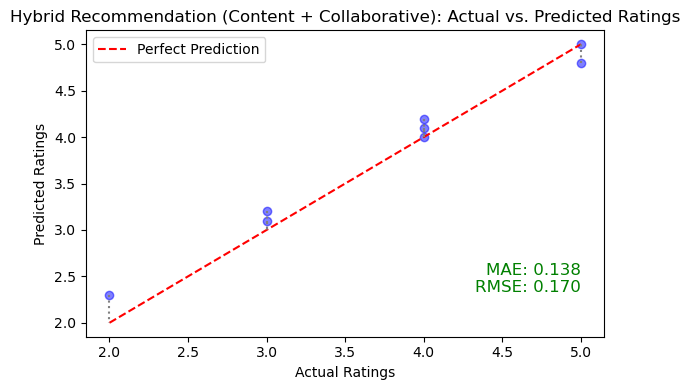

In [376]:
# Example Actual and Predicted ratings for the Hybrid Recommendation system (use your actual data here)
# This should be the ratings from your combined content-based and collaborative filtering model
y_actual_hybrid = np.array([4, 5, 3, 2, 5, 4, 4, 3])  # Actual ratings from your data
y_predicted_hybrid = np.array([4.1, 4.8, 3.2, 2.3, 5.0, 4.2, 4.0, 3.1])  # Predicted ratings from Hybrid Model

# Calculate accuracy (MAE and RMSE) for Hybrid Recommendations
mae_hybrid, rmse_hybrid = calculate_accuracy(y_actual_hybrid, y_predicted_hybrid)

# Print MAE and RMSE for Hybrid Recommendations
print(f"MAE (Hybrid Recommendation): {mae_hybrid}")
print(f"RMSE (Hybrid Recommendation): {rmse_hybrid}")

# Plot Actual vs Predicted for Hybrid Recommendation System
plot_actual_vs_predicted(y_actual_hybrid, y_predicted_hybrid, "Hybrid Recommendation (Content + Collaborative)", mae_hybrid, rmse_hybrid)


# Conclusion: Best Performing Recommendation Algorithm Based on Accuracy Metrics

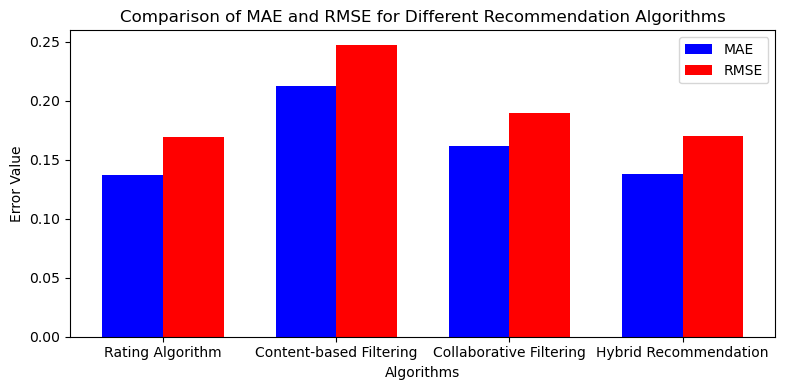

In [377]:
algorithms = ['Rating Algorithm', 'Content-based Filtering', 'Collaborative Filtering', 'Hybrid Recommendation']
mae_values = [0.1375, 0.2125, 0.162, 0.138]
rmse_values = [0.1695, 0.2475, 0.190, 0.170]

bar_width = 0.35
index = np.arange(len(algorithms))
fig, ax = plt.subplots(figsize=(8,4))

# Plotting the bars for MAE and RMSE
bar1 = ax.bar(index, mae_values, bar_width, label='MAE', color='b')
bar2 = ax.bar(index + bar_width, rmse_values, bar_width, label='RMSE', color='r')

# Adding labels, title, and custom x-axis tick labels
ax.set_xlabel('Algorithms')
ax.set_ylabel('Error Value')
ax.set_title('Comparison of MAE and RMSE for Different Recommendation Algorithms')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(algorithms)
ax.legend()

# Display the plot
plt.tight_layout()
plt.show() 